Summary/Objective:
The objective of this task is to analyze the "UCI Credit Card" dataset to predict if the consumer will default on their next month payment. The variables analyzed consists of individuals balance amount in dollars, sex, education level, marriage status, age, and their payment status. 

In [1]:
#Begin by importing the main libraries

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.preprocessing import StandardScaler

import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Begin by loading the "UCI Credit Card" data.
data=pd.read_csv("UCI_Credit_Card.csv")

### Phase 1: Data Cleaning

In [3]:
#Getting information about the data
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
data.shape #There are 30000 rows and 25 columns in the data

(30000, 25)

In [5]:
#Rename the default column for simplicity and drop ID column(unnececary)
data.rename(columns={'default.payment.next.month':"default"}, inplace=True)
data.drop("ID", axis=1, inplace=True)

In [6]:
#By inspecting the output above, I can see that there are no missing values. I will confirm this below as well. 
data.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

I can see that there are no missing values. Furthermore, all of the variables are numerical data types, even though, some are a categorical, such as, sex, education, and marriage. 

In [7]:
#Checking number of unique values in each category
data.nunique()

LIMIT_BAL       81
SEX              2
EDUCATION        7
MARRIAGE         4
AGE             56
PAY_0           11
PAY_2           11
PAY_3           11
PAY_4           11
PAY_5           10
PAY_6           10
BILL_AMT1    22723
BILL_AMT2    22346
BILL_AMT3    22026
BILL_AMT4    21548
BILL_AMT5    21010
BILL_AMT6    20604
PAY_AMT1      7943
PAY_AMT2      7899
PAY_AMT3      7518
PAY_AMT4      6937
PAY_AMT5      6897
PAY_AMT6      6939
default          2
dtype: int64

Variables with smaller number of unique values are likely classified as categorical.

In [8]:
#Checking unique values for marriage
data.MARRIAGE.unique()

array([1, 2, 3, 0])

In [9]:
#Checking education unique values
data.EDUCATION.unique()

array([2, 1, 3, 5, 4, 6, 0])

For Marriage variable: 3 and 0 are the same and for Education variable: 4, 5, and 6 are the same , so, combine them into one.

In [10]:
#For personal preference, I will represent values in catogorical variables as string types. This is not necessary. 
data.SEX.replace({1:'Male', 2:'Female'},inplace=True)
data.EDUCATION.replace({1:"Graduate",2:"University",3:"Highschool",4:"Other",5:"Other",6:"Other"},inplace=True)
data.MARRIAGE.replace({1:"Married",2:"Single",3:"Other",0:"Other"},inplace=True)
data.default.replace({1:"Yes",0:"No"}, inplace=True)

In [11]:
#Checking unique values for PAY
data.PAY_0.unique()

array([ 2, -1,  0, -2,  1,  3,  4,  8,  7,  5,  6])

In [12]:
#Combine -2 and -1 and represent them as 0.
data.PAY_0.replace({-2:0,-1:0}, inplace=True)
data.PAY_2.replace({-2:0,-1:0}, inplace=True)
data.PAY_3.replace({-2:0,-1:0}, inplace=True)
data.PAY_4.replace({-2:0,-1:0}, inplace=True)
data.PAY_5.replace({-2:0,-1:0}, inplace=True)
data.PAY_6.replace({-2:0,-1:0}, inplace=True)

In [13]:
#Double checking if data is modified correctly.
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000.0,Female,University,Married,24,2,2,0,0,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,Yes
1,120000.0,Female,University,Single,26,0,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,Yes
2,90000.0,Female,University,Single,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,No
3,50000.0,Female,University,Married,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,No
4,50000.0,Male,University,Married,57,0,0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,No


### Phase 2: Data Exploration

In [14]:
#Checking descrtiptive statistics of each feature
data.describe()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,0.356767,0.320033,0.304067,0.258767,0.22150,0.226567,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,0.760594,0.801727,0.790589,0.761113,0.71772,0.715438,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.00000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


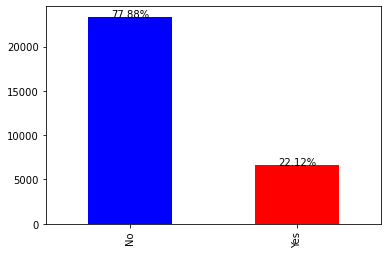

In [15]:
#Comparing percentage of defaults to non-defaults
data["default"].value_counts().plot.bar(color=['blue','red'])

total=len(data['default'])
not_def = len(data[data['default']=='No'])/total *100
yes_def = len(data[data['default']=="Yes"])/total *100

plt.text(x=0, y=len(data[data['default']=='No']),s=str("%.2f"%not_def+'%'),horizontalalignment='center')
plt.text(x=1, y=len(data[data['default']=="Yes"]),s=str("%.2f"%yes_def+'%'), horizontalalignment='center')

plt.show()

Individuals or partners have 22.12% chance of defaulting. The data is not balanced.

In [16]:
#Bivariate analysis of columns Sex, Education, and Marriage with default column
#Lets analyze the observation count of all value pairs using crosstab
count_SEX=pd.crosstab(data.SEX, data.default)
count_EDUCATION=pd.crosstab(data.EDUCATION, data.default)
count_MARRIAGE=pd.crosstab(data.MARRIAGE, data.default)
print(count_SEX,"\n")
print(count_EDUCATION,"\n")
print(count_MARRIAGE)

default     No   Yes
SEX                 
Female   14349  3763
Male      9015  2873 

default        No   Yes
EDUCATION              
0              14     0
Graduate     8549  2036
Highschool   3680  1237
Other         421    33
University  10700  3330 

default      No   Yes
MARRIAGE             
Married   10453  3206
Other       288    89
Single    12623  3341


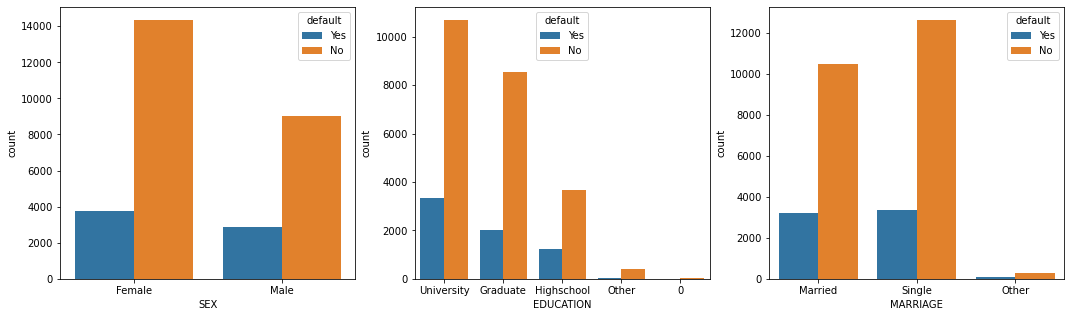

In [17]:
#Checking for relationships of categorical variables 
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.countplot(x='SEX', hue='default', data=data)
plt.subplot(1,3,2)
sns.countplot(x='EDUCATION', hue='default', data=data)
plt.subplot(1,3,3)
sns.countplot(x='MARRIAGE', hue='default', data=data)

plt.show()

On SEX variable, there are more females and female defaulters.
On EDUCATION variable, University degree holders default more, followed by Graduate holders.
On MARRIAGE variable, Singles tend to default more but there is not a lot of differences between. 

<AxesSubplot:xlabel='age_bins'>

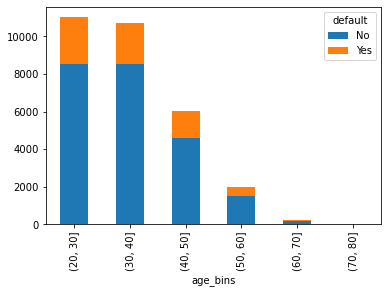

In [18]:
#Bivariate Analysis of LIMIT_BAL and AGE variables with the default variable.

data['age_bins']=pd.cut(data.AGE, bins=[20,30,40,50,60,70,80])
age_default=data.groupby(['age_bins','default']).AGE.count().unstack()

age_default.plot(kind='bar', stacked=True)

The amount of individuals defaulting is proportional to the total population of individuals in each age group but graph does indicate that individuals from age 20 to 40 are more likely to default.

<AxesSubplot:xlabel='default'>

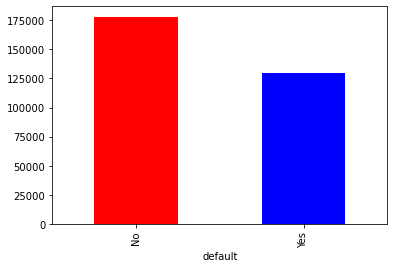

In [19]:
#Analyze LIMIT_BAL with default
data.groupby("default")['LIMIT_BAL'].mean().plot.bar(color=['red','blue'])


On average, Individuals/couples who received less NT dollars are likely to default more. 

<Figure size 1296x360 with 0 Axes>

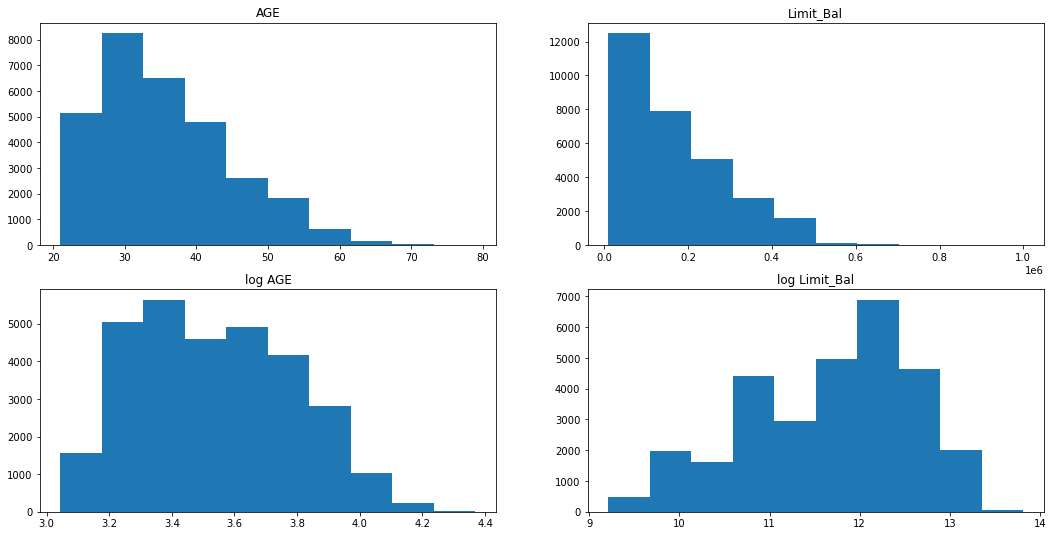

In [20]:
#Check the distribution of Limit_Bal and Age variables
plt.figure(figsize=(18,5))

#Check the distribution of Limit_Bal and Age variables
plt.figure(figsize=(18,9))
plt.subplot(2,2,1)
plt.hist((data.AGE))
plt.title("AGE")
plt.subplot(2,2,2)
plt.hist((data.LIMIT_BAL))
plt.title("Limit_Bal")

#Distributions after taking the log
plt.subplot(2,2,3)
plt.hist(np.log(data.AGE))
plt.title("log AGE")
plt.subplot(2,2,4)
plt.hist(np.log(data.LIMIT_BAL))
plt.title("log Limit_Bal")

#Replacing the better normally distributed data 
data['LIMIT_BAL']=np.log(data.LIMIT_BAL)
data['AGE']=np.log(data.AGE)

plt.show()

Created better normally distributed data of AGE and LIMIT_BAL by taking their log.

### Feature Engineering

In [21]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,age_bins
0,9.903488,Female,University,Married,3.178054,2,2,0,0,0,...,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,Yes,"(20, 30]"
1,11.695247,Female,University,Single,3.258097,0,2,0,0,0,...,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,Yes,"(20, 30]"
2,11.407565,Female,University,Single,3.526361,0,0,0,0,0,...,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,No,"(30, 40]"
3,10.819778,Female,University,Married,3.610918,0,0,0,0,0,...,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,No,"(30, 40]"
4,10.819778,Male,University,Married,4.043051,0,0,0,0,0,...,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,No,"(50, 60]"


<AxesSubplot:xlabel='default', ylabel='BILL_AMT6'>

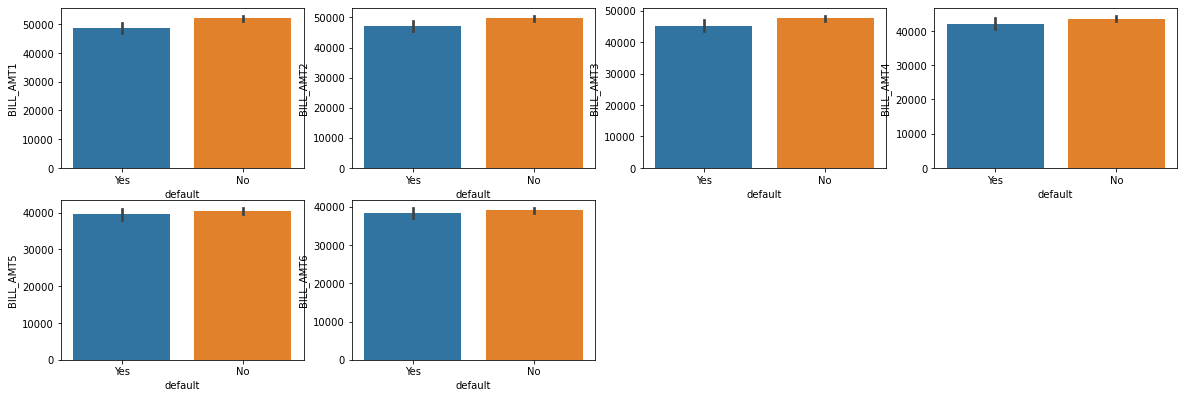

In [22]:
#Analyze Bill_AMT
plt.figure(figsize=(20,10))
plt.subplot(3,4,1)
sns.barplot(data.default, data.BILL_AMT1)
plt.subplot(3,4,2)
sns.barplot(data.default, data.BILL_AMT2)
plt.subplot(3,4,3)
sns.barplot(data.default, data.BILL_AMT3)
plt.subplot(3,4,4)
sns.barplot(data.default, data.BILL_AMT4)
plt.subplot(3,4,5)
sns.barplot(data.default, data.BILL_AMT5)
plt.subplot(3,4,6)
sns.barplot(data.default, data.BILL_AMT6)

<AxesSubplot:xlabel='default', ylabel='PAY_AMT6'>

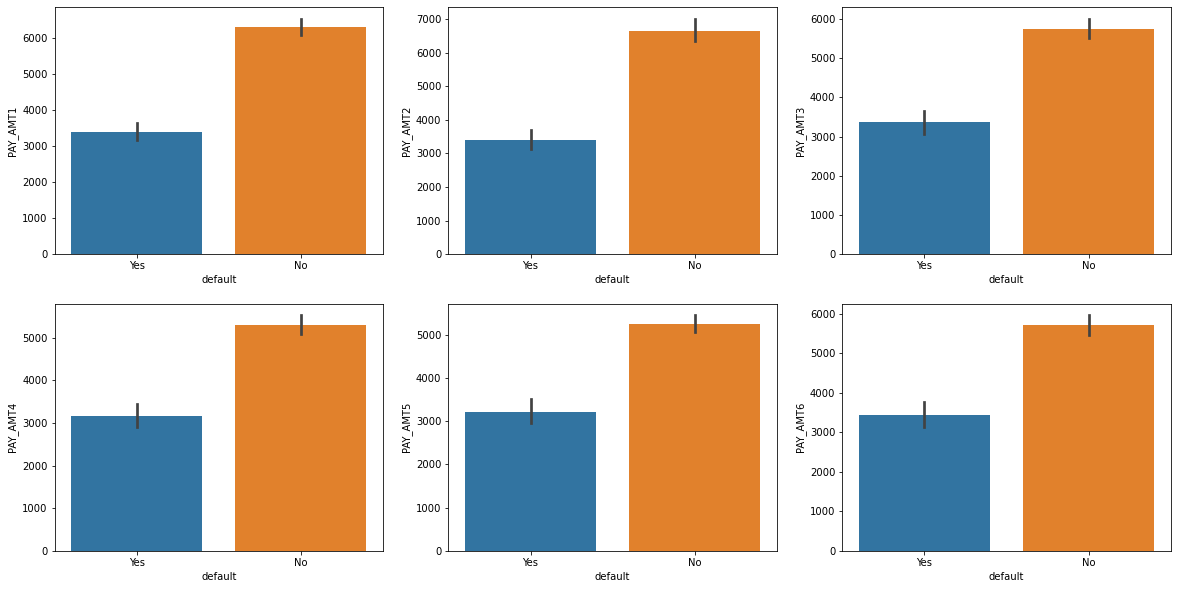

In [23]:
#Analyze Pay_AMT columns
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
sns.barplot(data.default, data.PAY_AMT1)

plt.subplot(2,3,2)
sns.barplot(data.default, data.PAY_AMT2)
plt.subplot(2,3,3)
sns.barplot(data.default, data.PAY_AMT3)
plt.subplot(2,3,4)
sns.barplot(data.default, data.PAY_AMT4)
plt.subplot(2,3,5)
sns.barplot(data.default, data.PAY_AMT5)
plt.subplot(2,3,6)
sns.barplot(data.default, data.PAY_AMT6)

Graph above indicates significant differences in PAY_AMT columns unlike in BILL_AMT columns. It seems that both groups are billed the similar amounts but defaulters pay less in average.  

<AxesSubplot:xlabel='PAY_6', ylabel='count'>

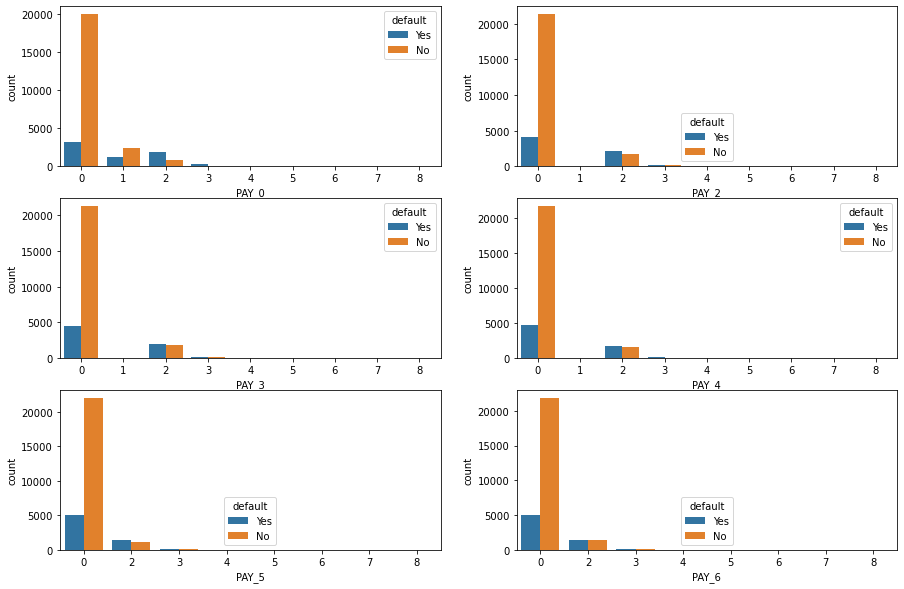

In [24]:
#Analyze the PAY columns
plt.figure(figsize=(15,10))
plt.subplot(3,2,1)
sns.countplot(x='PAY_0', hue='default', data=data)

plt.subplot(3,2,2)
sns.countplot(x='PAY_2', hue='default', data=data)

plt.subplot(3,2,3)
sns.countplot(x='PAY_3', hue='default', data=data)

plt.subplot(3,2,4)
sns.countplot(x='PAY_4', hue='default', data=data)

plt.subplot(3,2,5)
sns.countplot(x='PAY_5', hue='default', data=data)

plt.subplot(3,2,6)
sns.countplot(x='PAY_6', hue='default', data=data)

The graph above indicates that if individuals/partners will likely NOT default if payments are made ontime. However, if payments are late for 2-3 months, average numer of defaulters exceed the average number of non-defaulters. 

In [25]:
#Turn categorical variables back to numerical variables

data.SEX.replace({"Female":2 ,"Male":1}, inplace=True)
data.EDUCATION.replace({"Graduate":1,"University":2,"Highschool":3,"Other":4},inplace=True)
data.MARRIAGE.replace({"Married":1,"Single":2,"Other":3},inplace=True)
data.default.replace({"Yes":1,"No":0}, inplace=True)

In [26]:
#Looking into correlation between features and the target. Corr() can be used or heatmap. Heatmap provides a better visual.
#Look only to correlation between continuous and the target variables.  
abs(data.corr().loc[:,'default'].sort_values(ascending=False))

default      1.000000
PAY_0        0.396019
PAY_2        0.327093
PAY_3        0.286999
PAY_4        0.269055
PAY_5        0.260850
PAY_6        0.244437
EDUCATION    0.035197
AGE          0.007393
BILL_AMT6    0.005372
BILL_AMT5    0.006760
BILL_AMT4    0.010156
BILL_AMT3    0.014076
BILL_AMT2    0.014193
BILL_AMT1    0.019644
MARRIAGE     0.027575
SEX          0.039961
PAY_AMT6     0.053183
PAY_AMT5     0.055124
PAY_AMT3     0.056250
PAY_AMT4     0.056827
PAY_AMT2     0.058579
PAY_AMT1     0.072929
LIMIT_BAL    0.173571
Name: default, dtype: float64

<AxesSubplot:>

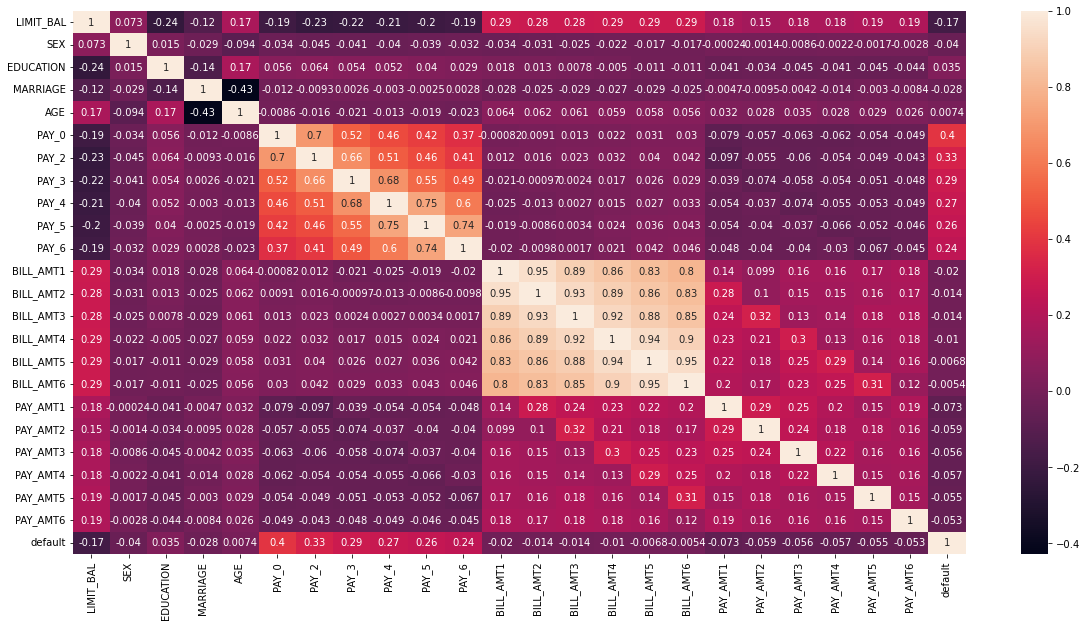

In [27]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), annot=True)

PAY_0 to PAY_6 variables are correlated more than others and will be selected as features.

### Train and Test Models

In [57]:
X=data[['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE']]
Y=data.default

#Scale 
X_scaled=StandardScaler().fit_transform(X)

In [29]:
#Split the data to 75, 25.
X_train,X_test, y_train, y_test= train_test_split(X_scaled,Y,test_size=0.25)

In [30]:
#Try GridSearchCV for Logistic Regression
#Define parameters
lr_params={'penalty':['l2','l1','none'],
           'solver':['newton-cg','lbfgs','liblinear','sag','saga']}

In [31]:
#Define base model
lr_grid_model=LogisticRegression()

#Implement GridSearch
lr_search = GridSearchCV(estimator=lr_grid_model, param_grid=lr_params, scoring='accuracy',cv=3)
lr_search.fit(X_train, y_train)

print(lr_search.best_params_)
print(lr_search.best_score_)

{'penalty': 'l2', 'solver': 'newton-cg'}
0.8181777777777778


In [32]:
#Using Logistic Regression with the best parameter obtained from GridSearchCV
start_time=time.time()

lr_model=LogisticRegression(solver='newton-cg')
lr_model.fit(X_train, y_train)

print("Train score: {:.2f}".format(lr_model.score(X_train,y_train)))
print("Test score: {:.2f}\n".format(lr_model.score(X_test, y_test)))

print("--- %s seconds ---" % (time.time() - start_time))

Train score: 0.82
Test score: 0.81

--- 0.04709482192993164 seconds ---


The scores are not that different, overfitting is not indicated and regularization is not needed. 

In [50]:
#predicting outputs using X_test
lr_pred=lr_model.predict(X_test)
lr1=accuracy_score(y_test,lr_pred)
confusion_report=confusion_matrix(y_test, lr_pred)

#Print the metrics for Logistic Regression Model
print(confusion_report)
accuracy_report=classification_report(y_test,lr_pred)
print(accuracy_report)

[[5573  247]
 [1146  534]]
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5820
           1       0.68      0.32      0.43      1680

    accuracy                           0.81      7500
   macro avg       0.76      0.64      0.66      7500
weighted avg       0.80      0.81      0.79      7500



Logistic Regression Model not doing well in capturing churned customers.

In [34]:
#Use Grid Search CV for Random Forest Model

#Define params
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}

#Define base model
rfc_model_grid=ensemble.RandomForestClassifier()

#Implement GridSearchCV
rfc_search = GridSearchCV(estimator=rfc_model_grid, param_grid=param_grid,scoring='accuracy')
rfc_search.fit(X_train, y_train)

print(rfc_search.best_params_)
print(rfc_search.best_score_)

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 21}
0.8215999999999999


In [35]:
#Using Random Forest
start_time=time.time()

rfc_model=ensemble.RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=37)
rfc_model.fit(X_train, y_train)

print("Random forest train score: {:.2f}".format(rfc_model.score(X_train,y_train)))
print("Random forest test score: {:.2f}\n".format(rfc_model.score(X_test, y_test)))

print("--- %s seconds ---" % (time.time() - start_time))

Random forest train score: 0.82
Random forest test score: 0.82

--- 0.19776201248168945 seconds ---


In [36]:
rfc_pred=rfc_model.predict(X_test)

rfc1=accuracy_score(y_test, rfc_pred)
rfc_confusion_report=confusion_matrix(y_test, rfc_pred)
print(rfc_confusion_report)
rfc_accuracy_report=classification_report(y_test,rfc_pred)
print(rfc_accuracy_report)

[[5516  304]
 [1061  619]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5820
           1       0.67      0.37      0.48      1680

    accuracy                           0.82      7500
   macro avg       0.75      0.66      0.68      7500
weighted avg       0.80      0.82      0.80      7500



In [40]:
#Use Grid Search for KNN

#Define params
param_grid = {'n_neighbors': [k for k in range(20)],
              'weights':['uniform','distance'],
             'algorithm':['ball_tree','kd_tree','brute']}

#Define base model
knn_model=KNeighborsClassifier()

#Implement GridSearchCV
knn_search = GridSearchCV(estimator=knn_model, param_grid=param_grid,scoring='accuracy')
knn_search.fit(X_train, y_train)

print(knn_search.best_params_)
print(knn_search.best_score_)

{'algorithm': 'kd_tree', 'n_neighbors': 19, 'weights': 'uniform'}
0.8180444444444446


In [47]:
#Using KNN Model with best parameters
start_time=time.time()

knn_model=KNeighborsClassifier(n_neighbors=19, weights='uniform', algorithm='kd_tree')
knn_model.fit(X_train, y_train)

print("KNN model train score: {:.2f}".format(knn_model.score(X_train,y_train)))
print("KNN model test score: {:.2f}\n".format(knn_model.score(X_test, y_test)))

print("--- %s seconds ---" % (time.time() - start_time))

KNN model train score: 0.82
KNN model test score: 0.81

--- 1.958425760269165 seconds ---


In [53]:
knn_pred=knn_model.predict(X_test)
knn1=accuracy_score(y_test, knn_pred)
knn_confusion_report=confusion_matrix(y_test, knn_pred)
print(knn_confusion_report)
knn_accuracy_report=classification_report(y_test, knn_pred)
print(knn_accuracy_report)

[[5490  330]
 [1063  617]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      5820
           1       0.65      0.37      0.47      1680

    accuracy                           0.81      7500
   macro avg       0.74      0.66      0.68      7500
weighted avg       0.80      0.81      0.79      7500



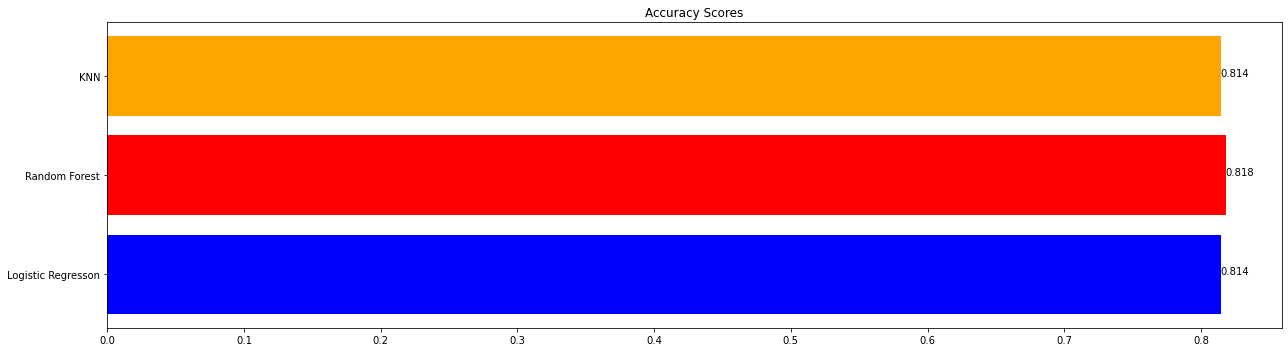

In [56]:
#Graphing accuracy scores
models=['Logistic Regresson','Random Forest','KNN']
accuracy1=[lr1, rfc1, knn1]

plt.figure(figsize=(18,5))
plt.barh(models,accuracy1, color=['blue','red','orange'])
plt.title("Accuracy Scores")
for i, val in enumerate(accuracy1):
    plt.text(val, i,
             str("%.3f"%val))
plt.tight_layout()

Results:
    
Based on the visualization techniques of indiviudal feature and their relationship to the target variable, most useful features that leads to defaulting of individual/partners include: 'LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5', and 'PAY_AMT6'.

I used the above features to train my LogisticRegression, Random Forest, and KNN Classifier models. Comparing the accuracy  and the data gathered from confusion matrix, Random Forest model is a little better to predict the outcome value. However, using Logistci Regression model will be much beneficial due to its processing time and performance, which is not that different than the performance of random forest.

The use of this model will highly benefit banks by allowing them to predict if a certain individual will default on their loan or not based on the features used above. This will lead banks to choose appropriate individuals to receive the loan and save money by reducing the number of loans given to individuals that are likely to default. 


Recommendation:

This model will correctly predict more than 80% of the population. Even though this is good, it does not predict 100% and banks will sometimes will loan an individual who will likely default. I believe including more features that would be more correlated with the target variable needs to be included in the data. Features can be credit score, individuals salary, and their total dept. 